Dataset source

https://www.kaggle.com/datasets/pushpakhinglaspure/cats-vs-dogs/data

Dataset was reduced 1,000 training images and 500 validation images for both dogs and cats.

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.data import AUTOTUNE

In [2]:
# Images directory
BASE_DIR = r'D:\datasets\dogs_vs_cats'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'test')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


print(f"Contents of base directory: {os.listdir(BASE_DIR)}")

print(f"\nContents of train directory: {train_dir}")

print(f"\nContents of validation directory: {validation_dir}")

Contents of base directory: ['test', 'train']

Contents of train directory: D:\datasets\dogs_vs_cats\train

Contents of validation directory: D:\datasets\dogs_vs_cats\test


In [3]:
# File names in images directory
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")

5 files in cats subdir: ['cat.0.jpg', 'cat.1.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.1001.jpg']
5 files in dogs subdir: ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.1000.jpg', 'dog.1001.jpg']


In [4]:
# Number of images
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog images: {len(os.listdir(train_dogs_dir))}')

print(f'total validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'total validation dog images: {len(os.listdir(validation_dogs_dir))}')

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
# Image examples
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cat_fnames, k=8)]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dog_fnames, k=8)]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at week_1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [7]:
# Data Preprocessing
# Instantiate the Dataset object for the training set
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary')

# Instantiate the Dataset object for the validation set
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
# Optimizing the datasets for training and validation
'''
cache() stores elements in memory as you use them so it will be faster to retrieve if you need them again
shuffle(), as the name suggests, shuffles the dataset randomly. A buffer_size of 1000 means it will first select a sample from the first week_1,000 elements, then keep filling this buffer until all elements have been selected.
prefetch() gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A buffer_size set to tf.data.AUTOTUNE dynamically sets the number of elements to prefetch during runtime.
'''

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

### Model

In [22]:
FILL_MODE = 'nearest'

inputs = Input(shape=(150,150,3))
# Augmentation Layers
rand_flip_layer = layers.RandomFlip("horizontal")(inputs)
rand_rot_layer = layers.RandomRotation(0.2, fill_mode=FILL_MODE)(rand_flip_layer)
rand_transl_layer = layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE)(rand_rot_layer)
rand_zoom_layer = layers.RandomZoom(0.2, fill_mode=FILL_MODE)(rand_transl_layer)

# Rescaling Layer
rescaling_layer = layers.Rescaling(1./255)(rand_zoom_layer)

# Convolution and Pooling layers
conv_layer_01 = layers.Conv2D(16, (3,3), activation='relu')(rescaling_layer)
mp_layer_01 = layers.MaxPooling2D(2,2)(conv_layer_01)
conv_layer_02 = layers.Conv2D(32, (3,3), activation='relu')(mp_layer_01)
mp_layer_02 = layers.MaxPooling2D(2,2)(conv_layer_02)
conv_layer_03 = layers.Conv2D(64, (3,3), activation='relu')(mp_layer_02)
mp_layer_03 = layers.MaxPooling2D(2,2)(conv_layer_03)
# Flatten the results to feed into a DNN
flatten_layer = layers.Flatten()(mp_layer_03)
# 512 neuron hidden layer
x = layers.Dense(512, activation='relu')(flatten_layer)
# Only week_1 output neuron. It will contain a value from 0-week_1 where 0 for one class ('dogs') and week_1 for the other ('cats')
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 150, 150, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",       # what to monitor
    patience=3,               # epochs to wait without improvement
    restore_best_weights=True)# roll back to best epoch

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",
    save_best_only=True)

history = model.fit(
    train_dataset_final,
    epochs=100,
    validation_data=validation_dataset_final,
    callbacks=[early_stop, checkpoint],
    verbose=2)

Epoch 1/100
100/100 - 24s - 235ms/step - accuracy: 0.5420 - loss: 0.7077 - val_accuracy: 0.6110 - val_loss: 0.6801
Epoch 2/100
100/100 - 9s - 86ms/step - accuracy: 0.6020 - loss: 0.6682 - val_accuracy: 0.6680 - val_loss: 0.6476
Epoch 3/100
100/100 - 9s - 87ms/step - accuracy: 0.6110 - loss: 0.6608 - val_accuracy: 0.6550 - val_loss: 0.6341
Epoch 4/100
100/100 - 8s - 81ms/step - accuracy: 0.6355 - loss: 0.6416 - val_accuracy: 0.5990 - val_loss: 0.6604
Epoch 5/100
100/100 - 9s - 90ms/step - accuracy: 0.6380 - loss: 0.6296 - val_accuracy: 0.6540 - val_loss: 0.6214
Epoch 6/100
100/100 - 9s - 88ms/step - accuracy: 0.6515 - loss: 0.6183 - val_accuracy: 0.6730 - val_loss: 0.6177
Epoch 7/100
100/100 - 9s - 87ms/step - accuracy: 0.6395 - loss: 0.6267 - val_accuracy: 0.6810 - val_loss: 0.5896
Epoch 8/100
100/100 - 8s - 81ms/step - accuracy: 0.6630 - loss: 0.6088 - val_accuracy: 0.6600 - val_loss: 0.6043
Epoch 9/100
100/100 - 9s - 86ms/step - accuracy: 0.6585 - loss: 0.6173 - val_accuracy: 0.6910 

In [25]:
def plot_history(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.

    Args:
        history (dict): The history.history dictionary returned by model.fit().
    """

    # Determine which keys to use for loss and accuracy
    # Keras uses 'accuracy'/'val_accuracy' or 'acc'/'val_acc'
    if 'accuracy' in history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    elif 'acc' in history:
        acc_key = 'acc'
        val_acc_key = 'val_acc'
    else:
        print("Could not find accuracy/acc keys in history.")
        return

    # Get the number of epochs
    epochs = range(1, len(history['loss']) + 1)
    
    # week_1. Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history[acc_key], 'b', label='Training Accuracy')
    plt.plot(epochs, history[val_acc_key], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout() # Adjusts plot to prevent overlap
    plt.show()

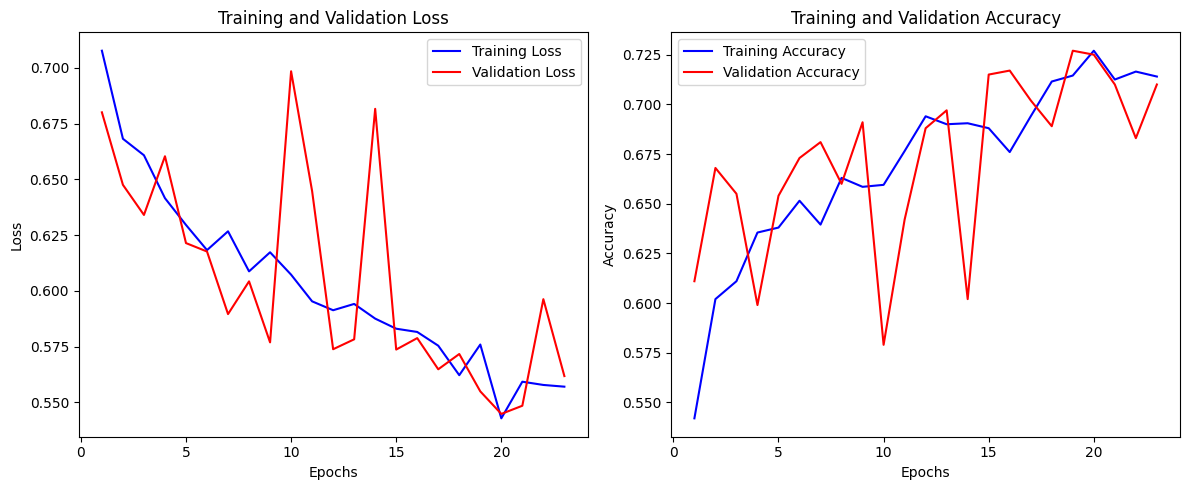

In [26]:
plot_history(history.history)

### Model Prediction

In [ ]:
def file_predict(filepath, image_name):
    """ A function for creating the prediction and printing the output."""
    image = load_img(filepath, target_size=(150, 150))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    if prediction > 0.5:
        print(image_name + " is a dog")
    else:
        print(image_name + " is a cat")

In [ ]:
image_for_predicting = '1024px-Cat_domestic'
downloads_dir = r'C:\Users\BlackySwanny\Downloads'
file_for_predicting =  os.path.join(downloads_dir, image_for_predicting + '.jpg')
file_predict(file_for_predicting, image_for_predicting)